In [28]:
import os
import requests
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 




In [57]:
urls = {
    "Demografi": "https://geoserver.mapid.io/layers_new/get_layer?api_key=92792608a1db4e0ea40072b92ce4abd0&layer_id=68aeff23abcfc44262fba593&project_id=68aeff08278efb81183bf81b&limit=10000",
    "Emisi Karbon" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=92792608a1db4e0ea40072b92ce4abd0&layer_id=68aeff32abcfc44262fba5e0&project_id=68aeff08278efb81183bf81b&limit=10000",
    "Tutupan Lahan" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=92792608a1db4e0ea40072b92ce4abd0&layer_id=68aeff3f278efb81183bf95e&project_id=68aeff08278efb81183bf81b&limit=10000"
}

#print setiap kolom pada masing-masing url
for name, url in urls.items():
    response = requests.get(url)
    data = response.json()
    if 'features' in data and len(data['features']) > 0:
        print(f"{name} columns: {list(data['features'][0]['properties'].keys())}")
    else:
        print(f"{name} has no features or invalid data.")



Demografi columns: ['fid', 'ID_PROV', 'PROVINSI', 'ID_KABKOT', 'KABKOT', 'ID_KEC', 'KECAMATAN', 'ID_DESA', 'DESA', 'JUMLAH PENDUDUK', 'JUMLAH KK', 'LUAS WILAYAH (KM²)', 'KEPADATAN PENDUDUK', 'KELAS']
Emisi Karbon columns: ['Densitas (µg/m³)', 'ISPU (Indeks Standar Pencemar Udara)', 'Kategori ISPU (Indeks Standar Pencemar Udara)', 'Kelas', 'DENSITAS']
Tutupan Lahan columns: ['CLASS', 'KELAS', 'KELAS_PL']


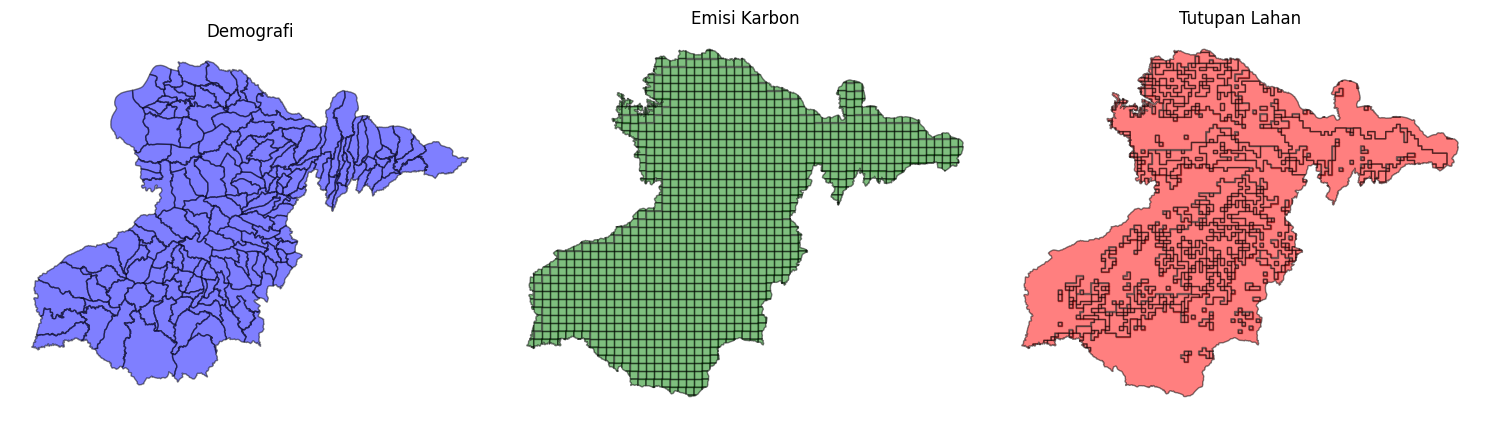

In [58]:


#menambahkan kolom skor di setiap layer
def get_data(url, layer_name):
    response = requests.get(url)
    if response.status_code == 200:
        geojson_data = response.json()
        gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

        # Menambahkan kolom skor berdasarkan variabel data
        if layer_name == "Demografi":
            gdf['SKOR_DEMOGRAFI'] = gdf.get('KELAS', '').str.upper().map({
                'RENDAH': 1,
                'SEDANG': 2,
                'TINGGI': 3,
            }).fillna(0)
        elif layer_name == "Emisi Karbon":
            gdf['SKOR_DENSITAS'] = gdf.get('DENSITAS', '').str.upper().map({
                'RENDAH': 1,
                'SEDANG': 2,
                'TINGGI': 3,
            }).fillna(0)
        elif layer_name == "Tutupan Lahan":
            gdf['SKOR_TUPLAH'] = gdf.get('KELAS_PL', '').str.upper().map({
                'RENDAH': 1,
                'SEDANG': 2,
                'TINGGI': 3,
            }).fillna(0)
        
        return gdf
    return gpd.GeoDataFrame()

# Mendapatkan data dari semua urls
gdf_demografi = get_data(urls["Demografi"], "Demografi")
gdf_densitas = get_data(urls["Emisi Karbon"], "Emisi Karbon")
gdf_tuplah = get_data(urls["Tutupan Lahan"], "Tutupan Lahan")

#Visualisasi data variabel menggunakan matplotlib
def visualize_data(gdfs):
    fig, axes = plt.subplots(1, len(gdfs), figsize=(15, 10))
    colors = ['blue', 'green', 'red']
    for ax, (name, gdf), color in zip(axes, gdfs.items(), colors):
        gdf.plot(ax=ax, color=color, edgecolor='black', alpha=0.5)
        ax.set_title(name)
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Menampilkan data untuk visualisasi
visualize_data({
    "Demografi": gdf_demografi,
    "Emisi Karbon": gdf_densitas,
    "Tutupan Lahan": gdf_tuplah
})

In [59]:
#Mengatasi Nilai Null
gdf_demografi.fillna({'SKOR_DEMOGRAFI': 0}, inplace=True)
gdf_densitas.fillna({'SKOR_DENSITAS': 0}, inplace=True)
gdf_tuplah.fillna({'SKOR_TUPLAH': 0}, inplace=True)

#Cek apakah ada nilai null
gdf_demografi.isnull().sum(), gdf_densitas.isnull().sum(), gdf_tuplah.isnull().sum()

#cek apakah data skor sudah ada
demo_cols = [col for col in ['KELAS', 'SKOR_DEMOGRAFI'] if col in gdf_demografi.columns]
dens_cols = [col for col in ['DENSITAS', 'SKOR_DENSITAS'] if col in gdf_densitas.columns]
tuplah_cols = [col for col in ['KELAS_PL', 'SKOR_TUPLAH'] if col in gdf_tuplah.columns]

gdf_demografi[demo_cols].head(), gdf_densitas[dens_cols].head(), gdf_tuplah[tuplah_cols].head()

(    KELAS  SKOR_DEMOGRAFI
 0  RENDAH               1
 1  RENDAH               1
 2  RENDAH               1
 3  RENDAH               1
 4  RENDAH               1,
   DENSITAS  SKOR_DENSITAS
 0   RENDAH              1
 1   RENDAH              1
 2   RENDAH              1
 3   RENDAH              1
 4   RENDAH              1,
   KELAS_PL  SKOR_TUPLAH
 0   TINGGI            3
 1   RENDAH            1
 2   TINGGI            3
 3   SEDANG            2
 4   RENDAH            1)

In [60]:
#Melakukan analisis intersect/overlay intersect
intersected_gdf = gdf_demografi
if not gdf_densitas.empty:
    intersected_gdf = gpd.overlay(intersected_gdf, gdf_densitas, how='intersection', keep_geom_type=False)
if not gdf_tuplah.empty:
    intersected_gdf = gpd.overlay(intersected_gdf, gdf_tuplah, how='intersection', keep_geom_type=False)

# fix geometry
intersected_gdf = intersected_gdf[intersected_gdf.geometry.type == 'Polygon']
intersected_gdf['geometry'] = intersected_gdf['geometry'].apply(lambda x : x.make_valid()if not x.is_valid else x)

# Mengatasi nilai null setelah intersect
intersected_gdf.fillna({'SKOR_DEMOGRAFI': 0, 'SKOR_DENSITAS': 0, 'SKOR_TUPLAH': 0}, inplace=True)

# Menambahkan kolom total skor
intersected_gdf['TOTAL_SKOR'] = (
    intersected_gdf.get('SKOR_DEMOGRAFI', 0) + intersected_gdf.get('SKOR_DENSITAS', 0) + intersected_gdf.get('SKOR_TUPLAH', 0)
)

# Klasifikasi 3 kelas untuk KESESUAIAN
intersected_gdf['KESESUAIAN'] = pd.cut(
    intersected_gdf['TOTAL_SKOR'],
    bins=[2, 5, 7, 9],
    labels=['RENDAH', 'SEDANG', 'TINGGI'],
    include_lowest=True)

print(intersected_gdf[['SKOR_DEMOGRAFI', 'SKOR_DENSITAS', 'SKOR_TUPLAH', 'TOTAL_SKOR', 'KESESUAIAN']].head(10))


   SKOR_DEMOGRAFI  SKOR_DENSITAS  SKOR_TUPLAH  TOTAL_SKOR KESESUAIAN
0               1              3            1           5     RENDAH
1               1              3            1           5     RENDAH
2               1              2            1           4     RENDAH
3               1              3            3           7     SEDANG
4               1              3            2           6     SEDANG
5               1              3            1           5     RENDAH
6               1              3            3           7     SEDANG
7               1              3            2           6     SEDANG
8               1              3            1           5     RENDAH
9               1              3            3           7     SEDANG


In [61]:
# Memviasualisasi hasil klasifikasi kesesuaian dalam peta
if intersected_gdf.crs is None:
    intersected_gdf.set_crs(epsg=4326, inplace=True)
elif intersected_gdf.crs.to_epsg() != 4326:
    intersected_gdf = intersected_gdf.to_crs(epsg=4326)
# Menampilkan kelas kesesuaian
intersected_gdf['KESESUAIAN'] = intersected_gdf['KESESUAIAN'].astype(str)
# Membuat peta dengan folium
m = folium.Map(location=[-6.9175, 107.6191], zoom_start=12)
folium.GeoJson(
    intersected_gdf,
    name='Kesesuaian',
    style_function=lambda feature: {
        'fillColor': {
            'RENDAH': 'green',
            'SEDANG': 'yellow',
            'TINGGI': 'red'
        }.get(feature['properties']['KESESUAIAN'], 'gray'),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['KESESUAIAN', 'TOTAL_SKOR'],
        aliases=['Kesesuaian:', 'Total Skor:'],
        localize=True,
        sticky=True,
        labels=True,
        style="background-color: white; color: black; font-family: Arial; font-size: 12px;"
    )
).add_to(m)
# Menambahkan kontrol layer
folium.LayerControl().add_to(m)

# Menyimpan peta ke file HTML
output_file = 'map_kesesuaian.html'
m.save(output_file)
print(f"Peta kesesuaian telah disimpan ke {output_file}")

Peta kesesuaian telah disimpan ke map_kesesuaian.html


In [64]:
#Simpan ke GeoJSON
import os

output_dir = r"C:\Ghilba\Mapid\Sesi Pythone"
os.makedirs(output_dir, exist_ok=True)

#ambil data multipolygon dan polygon
intersected_gdf_multi = intersected_gdf[intersected_gdf.geometry.type.isin(['MultiPolygon', 'Polygon'])]

# memperbaiki geometri
intersected_gdf_multi['geometry'] = intersected_gdf_multi['geometry'].apply(lambda x: x.make_valid() if not x.is_valid else x)

#simpan hasil data
intersected_gdf_multi.to_file(os.path.join(output_dir, 'hasil_kesesuaian.geojson'), driver='GeoJSON')

print(f"Hasil kesesuaian telah disimpan di : {output_dir}")

Hasil kesesuaian telah disimpan di : C:\Ghilba\Mapid\Sesi Pythone
